### Sandbox Description
This notebook experiments with the usage of sensor placement, sparsity, lags, and various other variables within the SHRED system to see how developers can optimize their usage of SHRED for forecasting and reconstruction of various spatiotemporal datasets. In this example, we use the 1990 sea surface temperature dataset provided in the PySHRED docs.

In [58]:
# Import all dependencies
import pyshred
from pyshred import *
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt


# Initialize our dataset
sst_dataset = xr.open_dataset("sst.wkmean.1990-present.nc")
mask_dataset = xr.open_dataset("lsmask.nc")

data = sst_dataset["sst"].values
mask = np.squeeze(mask_dataset["mask"].values)

data[:, mask==0] = 0

# data stores an entire SST map for every index, where indices are timesteps in weeks

In [59]:
# This represents how much of our entire dataset we want to work with
start_week = 0 # default
end_week = int(input(f"Last week to include in data (size is {len(data)}): "))

Text(0.5, 1.0, 'Weekly Sea Surface Temperature, Week 1700')

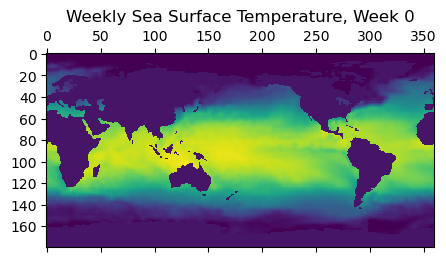

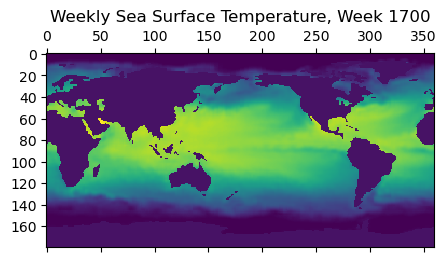

In [60]:
# Let's visualize the first and last week of data!
# Visually, this should give us an idea of what the trajectory of our data looks like
fig, ax = plt.subplots(figsize=(5, 4))
ax.matshow(data[start_week])
ax.set_title(f"Weekly Sea Surface Temperature, Week {start_week}")

fig, ax = plt.subplots(figsize=(5, 4))
ax.matshow(data[end_week])
ax.set_title(f"Weekly Sea Surface Temperature, Week {end_week}")

Now let's set up our sensor locations: one "sparse" vector to store a few tuples of coordinates, and a "dense" vector to capture more coordinates.

In [61]:
# Used to compare performance of using different amounts of sensors
# in well placed locations.
sparse_locations = [(75, 165), (90, 225), (120, 175)]
dense_locations = [(75, 165), (90, 225), (120, 175), (115, 255), (110, 225), (100, 100)]

And let's define how much data to use to train our forecaster SHRED models to then compare to the rest of the ground truth

In [62]:
# Isolating half of the dataset to see if the SHRED forecast can predict beyond the test split of the whole dataset
# This will be used for both sparse and numerous sensor location tests
data_length = end_week // 2
isolated_data = data[:data_length]

Now let's initialize two DataManagers: to one we will only add the sparse datapoints, and to the other we will add the dense, more complete-picture datapoints.

In [63]:
# Define ratios
TRAIN_RATIO = 0.9
VAL_RATIO = 0.05
TEST_RATIO = 0.05

# Initialize sparse data manager
sparse_manager = DataManager(
    lags=52, # 52 weeks means short-term memory used to train SHRED model's LSTM will be a year long
    train_size=TRAIN_RATIO, 
    val_size=VAL_RATIO,
    test_size=TEST_RATIO,
)

sparse_manager.add_data(
    data=isolated_data,
    id="My_Sparse_SST",
    stationary=sparse_locations,
    compress=False
)

# Initialize dense data manager
dense_manager = DataManager(
    lags=52,
    train_size=TRAIN_RATIO,
    val_size=VAL_RATIO,
    test_size=TEST_RATIO,
)  

dense_manager.add_data(
    data=isolated_data,
    id="My_Dense_SST",
    stationary=dense_locations,
    compress=False
)

In [64]:
# Preview sparse and dense sensor measurements
sparse_manager.sensor_measurements_df

,My_Sparse_SST-0,My_Sparse_SST-1,My_Sparse_SST-2
0,27.830000,25.709999,22.320000
1,27.539999,25.779999,22.289999
2,27.250000,25.289999,23.549999
3,27.129999,25.500000,22.969999
4,27.019999,25.670000,23.740000
...,...,...,...
845,26.889999,25.000000,22.910000
846,26.840000,25.180000,23.049999
847,26.879999,25.480000,23.160000
848,27.099998,26.500000,23.170000


In [65]:
# Preview sparse and dense sensor measurements
dense_manager.sensor_measurements_df

,My_Dense_SST-0,My_Dense_SST-1,My_Dense_SST-2,My_Dense_SST-3,My_Dense_SST-4,My_Dense_SST-5
0,27.830000,25.709999,22.320000,24.500000,27.410000,28.059999
1,27.539999,25.779999,22.289999,24.820000,27.349998,27.750000
2,27.250000,25.289999,23.549999,24.719999,27.299999,27.900000
3,27.129999,25.500000,22.969999,24.189999,27.570000,28.129999
4,27.019999,25.670000,23.740000,24.209999,27.019999,28.199999
...,...,...,...,...,...,...
845,26.889999,25.000000,22.910000,25.320000,28.309999,29.459999
846,26.840000,25.180000,23.049999,24.959999,28.410000,29.449999
847,26.879999,25.480000,23.160000,24.959999,28.320000,29.209999
848,27.099998,26.500000,23.170000,24.629999,28.580000,28.769999


Now let's prepare two SHRED models: one using training/validation/testing data prepared by the sparse data manager, and the other using the one with more numerous sensors.

In [66]:
# Prepare sparse and dense train test val splits
sparse_train, sparse_val, sparse_test = sparse_manager.prepare()
dense_train, dense_val, dense_test = dense_manager.prepare()

# You can even define your own decoder and LSTM models here.
# Remember that the coupling is super flexible, so long as
# LSTM/temporal model outputs a final hidden state that can
# be used by the decoder model to output a full state space
sparse_shred = SHRED(
    sequence_model="LSTM",
    decoder_model="MLP",
    latent_forecaster="LSTM_Forecaster"
)

dense_shred = SHRED(
    sequence_model="LSTM",
    decoder_model="MLP",
    latent_forecaster="LSTM_Forecaster"
)

# Fit sparse and dense SHRED models, set epochs to 2 for brevity, increase if preferred
epoch_limit = 2

sparse_val_errors = sparse_shred.fit(
    train_dataset=sparse_train,
    val_dataset=sparse_val,
    num_epochs=epoch_limit,
    verbose=False
)

dense_val_errors = dense_shred.fit(
    train_dataset=dense_train,
    val_dataset=dense_val,
    num_epochs=epoch_limit,
    verbose=False
)

print(f"Sparse SHRED model's validation error: {sparse_val_errors}\nDense SHRED model's validation error: {dense_val_errors}\n")

Fitting SHRED...
Fitting SHRED...
Sparse SHRED model's validation error: [0.04947853 0.03881036]
Dense SHRED model's validation error: [0.04742055 0.03916777]



Evaluate the sparse and dense shred models

In [67]:
sparse_train_mse = sparse_shred.evaluate(dataset=sparse_train)
sparse_val_mse = sparse_shred.evaluate(dataset=sparse_val)
sparse_test_mse = sparse_shred.evaluate(dataset=sparse_test)

dense_train_mse = dense_shred.evaluate(dataset=dense_train)
dense_val_mse = dense_shred.evaluate(dataset=dense_val)
dense_test_mse = dense_shred.evaluate(dataset=dense_test)

print("Sparse Train MSE: ", sparse_train_mse)
print("Sparse Validation MSE: ", sparse_val_mse)
print("Sparse Test MSE: ", sparse_test_mse)

print("Dense Train MSE: ", dense_train_mse)
print("Dense Validation MSE: ", dense_val_mse)
print("Dense Test MSE: ", dense_test_mse)


Sparse Train MSE:  0.038640509637496975
Sparse Validation MSE:  0.03881036488187096
Sparse Test MSE:  0.046147459535601495
Dense Train MSE:  0.03878197495562011
Dense Validation MSE:  0.0391677747005438
Dense Test MSE:  0.0463724698535745


In order to run forecasting and reconstruction, we need to initialize sparse and dense SHRED engines that can turn our sensor measurement data into latents to train a sensor forecaster and turn forecasted and future sensor measurement tensors into full state reconstructions through SHRED's decoder.

In [68]:
sparse_engine = SHREDEngine(sparse_manager, sparse_shred)
dense_engine = SHREDEngine(dense_manager, dense_shred)

sparse_test_latents = sparse_engine.sensor_to_latent(sparse_manager.test_sensor_measurements)
sparse_val_latents = sparse_engine.sensor_to_latent(sparse_manager.val_sensor_measurements)

dense_test_latents = dense_engine.sensor_to_latent(dense_manager.test_sensor_measurements)
dense_val_latents = dense_engine.sensor_to_latent(dense_manager.val_sensor_measurements)

# Set up the forecaster and seed it with a bunch of the validation
# dataset's latent states.
sparse_init_latents = sparse_val_latents[-sparse_shred.latent_forecaster.seed_length:]
dense_init_latents = dense_val_latents[-dense_shred.latent_forecaster.seed_length:]

h = len(sparse_manager.test_sensor_measurements) # Testing the forecaster requires us to use h "future steps" where h is the length of the testing data, which is what we aim to predict with sensor forecaster initially.

# This is the big one: creating H steps of forecasted latents that are DIRECTLY
# COMPARABLE to the ground truth testing latents. In other words, we are first "predicting"
# what the test dataset's latents should be, then we can compare that to the actual
# testing dataset's latents.
test_latent_from_forecaster = sparse_engine.forecast_latent(h=h, init_latents=sparse_init_latents)
dense_latents_from_forecaster = dense_engine.forecast_latent(h=h, init_latents=dense_init_latents)

# So we can compare the differences in the latent states, techjnically, even before
# we reconstruct the full state from it by decoding.
mse = np.mean((test_latent_from_forecaster - sparse_test_latents)**2)
mse_2 = np.mean((dense_latents_from_forecaster - dense_test_latents)**2)
print("MSE of sparse test latents from forecasted latents: ", mse)
print("MSE of dense test latents from forecasted latents: ", mse_2)

MSE of sparse test latents from forecasted latents:  0.00019806424
MSE of dense test latents from forecasted latents:  0.00025863762


After running the MSE tests from above, it is more than likely that the dense test latents that are generated will be more accurate (lower MSE) than the MSE of sparse test latents. That's because the latents used to seed the sensor forecaster with the dense sensor data are more data-rich than the sparse sensor data, making the result closer to the real sensor data.

Now let's run reconstruction and forecasting.

Sparse MSE:  0.0002756476
Dense MSE:  0.0031342448


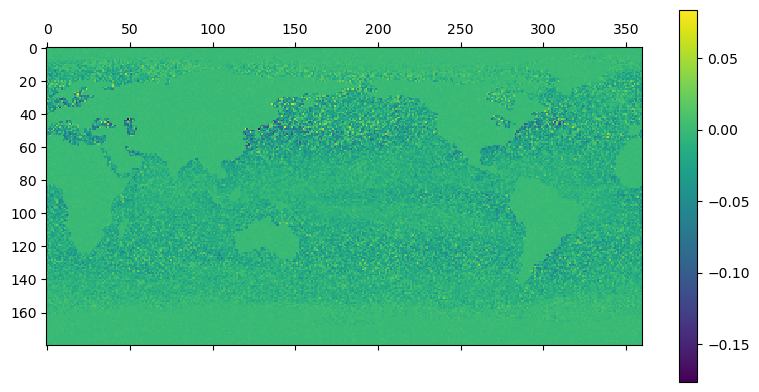

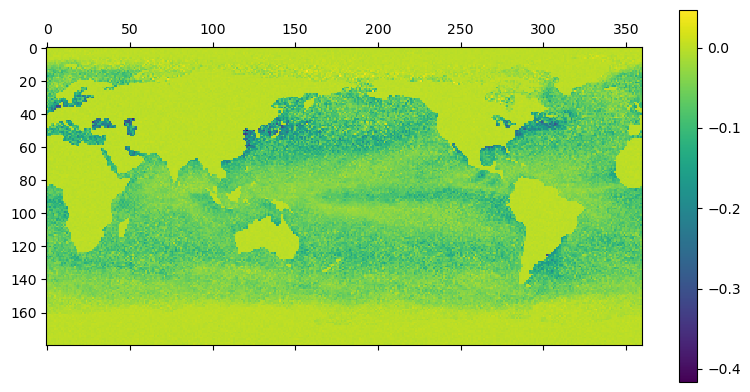

In [69]:
sparse_test_reconstruction = sparse_engine.decode(sparse_test_latents)
sparse_test_forecast = sparse_engine.decode(test_latent_from_forecaster)

dense_test_reconstruction = dense_engine.decode(dense_test_latents)
dense_test_forecast = dense_engine.decode(dense_latents_from_forecaster)

print("Sparse MSE: ", np.mean((sparse_test_reconstruction['My_Sparse_SST'][0] - sparse_test_forecast['My_Sparse_SST'][0])**2))
print("Dense MSE: ", np.mean((dense_test_reconstruction['My_Dense_SST'][0] - dense_test_forecast['My_Dense_SST'][0])**2))

plt.matshow(sparse_test_reconstruction['My_Sparse_SST'][0] - sparse_test_forecast['My_Sparse_SST'][0])
plt.colorbar()

plt.matshow(dense_test_reconstruction['My_Dense_SST'][0] - dense_test_forecast['My_Dense_SST'][0])
plt.colorbar()


In [70]:
# Now we're gonna use that futute forecaster to really see into the future,
# and see how accurate we are.

# First, get the latents from the future sensor measurements (after the isolated data)
# Then, use the decoder to decode those latents into full state spaces.
# Then, get hte MSE between those latents and the actual future sensor measurements.

future_manager_sparse = DataManager(
    lags=104,
    train_size=TRAIN_RATIO,
    val_size=VAL_RATIO,
    test_size=TEST_RATIO
)

future_manager_dense = DataManager(
    lags=104,
    train_size=TRAIN_RATIO,
    val_size=VAL_RATIO,
    test_size=TEST_RATIO
)

# dense_val_errors = dense_shred.fit(
#     train_dataset=dense_train,
#     val_dataset=dense_val,
#     num_epochs=epoch_limit,
#     verbose=False
# )

# Add our ground truth data, data that our previous
# SHRED models and sensor forecasters have never seen,
# and will be forced to predict.
future_manager_sparse.add_data(
    data=data,
    id="Sparse_Future_SST",
    stationary=sparse_locations,
)

future_manager_dense.add_data(
    data=data,
    id="Dense_Future_SST",
    stationary=dense_locations,
)

sparse_train, sparse_val, sparse_test = future_manager_sparse.prepare()

epoch_limit = 10
sparse_val_errors = sparse_shred.fit(
    train_dataset=sparse_train,
    val_dataset=sparse_val,
    num_epochs=epoch_limit,
    verbose=False
)

dense_train, dense_val, dense_test = future_manager_dense.prepare()

epoch_limit = 10
dense_val_errors = dense_shred.fit(
    train_dataset=dense_train,
    val_dataset=dense_val,
    num_epochs=epoch_limit,
    verbose=False
)

sparse_engine = SHREDEngine(future_manager_sparse, sparse_shred)
dense_engine = SHREDEngine(future_manager_dense, dense_shred)

# Remember that since we passed a limited scope of data to the future data managers,
# the train_sensor_measurements will capture the data from the start of the ground truth
# dataset, and that's ultimately what we are comparing against anyways. An alternative
# way could be to pass the entire dataset, and then use test_sensor_measurements instead

h = len(future_manager_sparse.test_sensor_measurements)

sparse_val_latents = sparse_engine.sensor_to_latent(future_manager_sparse.val_sensor_measurements)
sparse_init_latents = sparse_val_latents[-sparse_shred.latent_forecaster.seed_length:]

sparse_engine.forecast_latent(h=h, init_latents=sparse_init_latents)
future_latents_sparse = sparse_engine.sensor_to_latent(future_manager_sparse.test_sensor_measurements)
sparse_future_reconstruction = sparse_engine.decode(future_latents_sparse)

dense_val_latents = dense_engine.sensor_to_latent(future_manager_dense.val_sensor_measurements)
dense_init_latents = dense_val_latents[-dense_shred.latent_forecaster.seed_length:]

dense_engine.forecast_latent(h=h, init_latents=dense_init_latents)
future_latents_dense = dense_engine.sensor_to_latent(future_manager_dense.test_sensor_measurements)
dense_future_reconstruction = dense_engine.decode(future_latents_dense)

Fitting SHRED...
Fitting SHRED...


MSE of reconstruction: 7.27328634262085


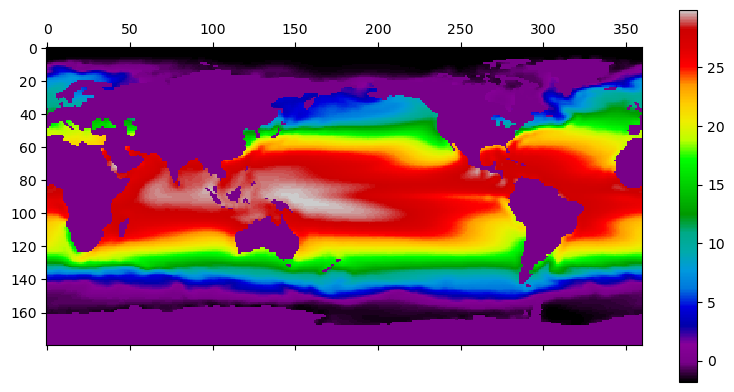

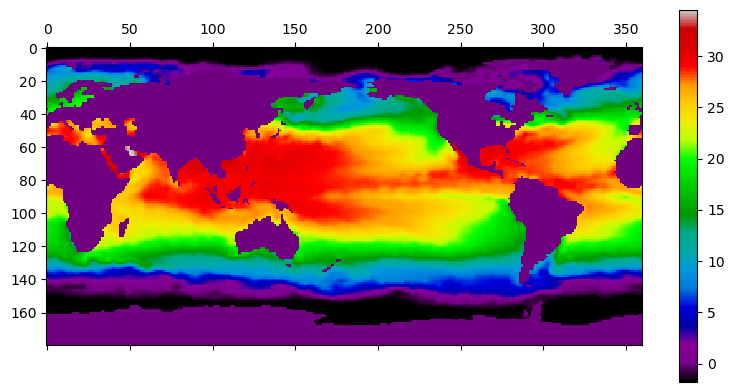

In [82]:
future_index = 0
ground_index = 1700

plt.matshow(sparse_future_reconstruction['Sparse_Future_SST'][0], cmap='nipy_spectral')
plt.colorbar()

plt.matshow(data[1700], cmap='nipy_spectral')
plt.colorbar()

print(f"MSE of reconstruction: {np.mean((sparse_future_reconstruction['Sparse_Future_SST'][future_index] - data[ground_index])**2)}")

Now below, if we use the dense sensor measurements, we will find that forecasting is much more accurate and generates a forecast of the evolution of the sea surface temperatures much better than the sparse sensor measurements. In conclusion, more well-placed sensors allows SHRED to learn POD modes/functions, as well as train latent layers within the model, that are far more representative of the true evolution of the data.

MSE of reconstruction: 1.521714687347412


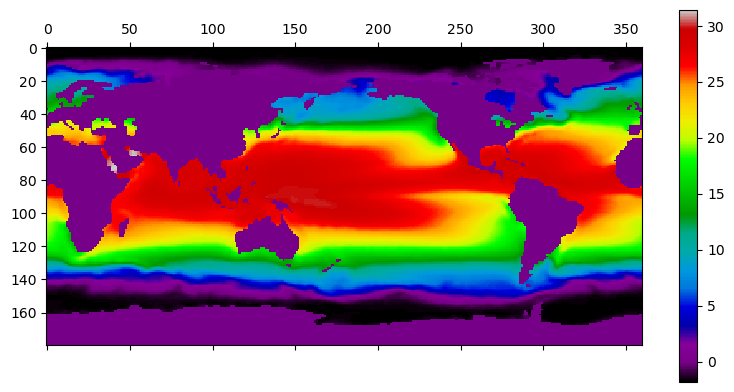

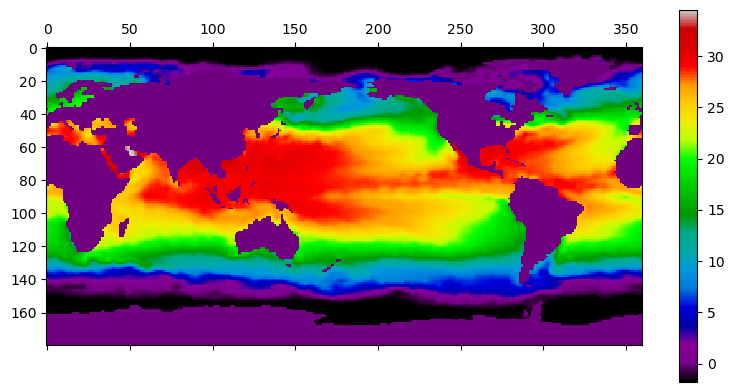

In [84]:
future_index = 0
ground_index = len(data)-dense_future_reconstruction['Dense_Future_SST'].shape[0]

plt.matshow(dense_future_reconstruction['Dense_Future_SST'][0], cmap='nipy_spectral')
plt.colorbar()

plt.matshow(data[1700], cmap='nipy_spectral')
plt.colorbar()

print(f"MSE of reconstruction: {np.mean((dense_future_reconstruction['Dense_Future_SST'][future_index] - data[ground_index])**2)}")

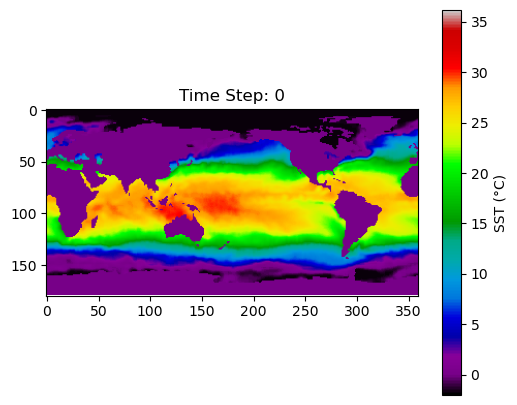

In [86]:
import matplotlib.animation as animation
import numpy as np

animation_limit = 1786
data_sequence = np.vstack((data, dense_future_reconstruction['Dense_Future_SST']))

fig, ax = plt.subplots(figsize=(6, 5))

vmin = np.min(data_sequence)
vmax = np.max(data_sequence)

im = ax.imshow(data_sequence[0], cmap='nipy_spectral', vmin=vmin, vmax=vmax)
plt.colorbar(im, ax=ax, label='SST (°C)')
title = ax.set_title("Time Step: 0")

def update(i):
    im.set_data(data_sequence[i])
    title.set_text(f"Time Step: {i}")
    return im, title

ani = animation.FuncAnimation(fig, update, frames=animation_limit, interval=50, blit=False)

plt.show()
ani.save('sst_reconstruction.gif', writer='pillow', fps=15)